In [34]:
import json
from tld import get_fld
import csv
import os.path
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns


In [35]:
page_load_time_desktop=[]
page_load_time_mobile=[]
num_requests_desktop=[]
num_requests_mobile=[]
num_third_parties_desktop=[]
num_third_parties_mobile=[]
num_trackers_domain_desktop=[]
num_trackers_domain_mobile=[]
num_trackers_ent_desktop=[]
num_trackers_ent_mobile=[]


third_parties_desktop_list=[]
third_parties_mobile_list=[]
tracker_domain_desktop_list=[]
tracker_domain_mobile_list=[]
tracker_ent_desktop_list=[]
tracker_ent_mobile_list=[]

analysis_websites_desktop=[]
analysis_tranco_desktop=[]

analysis_websites_mobile=[]
analysis_tranco_mobile=[]





In [36]:
#load the disconnect blocklist as top level domains
f = open('services.json') 
disconnect = json.load(f) 
disconnect=disconnect['categories']
disconnect_blocklist=[]
for entry in disconnect:
    domain_list=disconnect[entry]
    for item in domain_list:
        keys=item.keys()
        for key, value in item.items():
            for inner_key,inner_value in value.items():
                for element in inner_value:
                    if len(element)>1:
                        disconnect_blocklist.append(element)




In [37]:
f = open('domain_map.json') 
domain_map = json.load(f) 

In [38]:
def get_page_load_time(website):
    start_time=website['pageload_start_ts']
    end_time=website['pageload_end_ts']
    return end_time-start_time

In [39]:
def get_num_requests(website):
    return len(website['requests'])


In [40]:
def get_third_parties(website):
    third_party_domains=set()
    first_domain=website['domain']
    for req in website['requests']:
        req_domain=get_fld(req['request_url'])
        if (req_domain!=first_domain):
            third_party_domains.add(req_domain)
    third_party_domains=list(third_party_domains)
    return third_party_domains

In [41]:
def get_tracker_domains(third_party_list):
    tracker_domains=set()
    for item in third_party_list:
        if item in disconnect_blocklist:
            tracker_domains.add(item)
    tracker_domains_to_list=(list)(tracker_domains)
    return tracker_domains_to_list

In [42]:
def get_tracker_entity (tracker_name):
    if tracker_name in domain_map.keys():
        return domain_map[tracker_name]['entityName']
    else:
        return "not found"
        

In [43]:
urls=[]
tranco_rank=[]
with open('tranco-top-500-safe.csv') as file:
                data = csv.reader(file,delimiter=',')
                for url_data in data:
                    urls.append(url_data[1])
                    tranco_rank.append(url_data[0])
urls.remove("domain")
tranco_rank.remove("tranco_rank")

In [44]:
def get_tranco_rank(website_name):
    index=urls.index(website_name)
    return tranco_rank[index]

In [45]:
def get_crawl_data(type):
    for entry in urls:
        file_name='analysis/'+entry+'_'+type+'.json'
        if (os.path.exists(file_name)):
            current= open(file_name) 
            website_dict = json.load(current)
            page_load=get_page_load_time(website_dict)
            req_count=get_num_requests(website_dict)
            third_parties=get_third_parties(website_dict)
            tracker_entities=set()
            tracker_domains=get_tracker_domains(third_parties)
            for tracker in tracker_domains:
                tracker_entities.add(get_tracker_entity(tracker))
            tracker_entities=list(tracker_entities)
            if (type=='desktop'):
                page_load_time_desktop.append(page_load)
                num_requests_desktop.append(req_count)
                for domain in third_parties:
                    third_parties_desktop_list.append(domain)
                
                for t in tracker_domains:
                    tracker_domain_desktop_list.append(t)
                
                for e in tracker_entities:
                    tracker_ent_desktop_list.append(e)

                num_third_parties_desktop.append(len(third_parties))
                num_trackers_domain_desktop.append(len(tracker_domains))
                num_trackers_ent_desktop.append(len(tracker_entities))

                analysis_tranco_desktop.append(get_tranco_rank(website_dict['domain']))
                
            else: 
                page_load_time_mobile.append(page_load)
                num_requests_mobile.append(req_count)
                for domain in third_parties:
                    third_parties_mobile_list.append(domain)
                
                for t in tracker_domains:
                    tracker_domain_mobile_list.append(t)
                
                for e in tracker_entities:
                    tracker_ent_mobile_list.append(e)

                num_third_parties_mobile.append(len(third_parties))
                num_trackers_domain_mobile.append(len(tracker_domains))
                num_trackers_ent_mobile.append(len(tracker_entities))
                analysis_tranco_mobile.append(get_tranco_rank(website_dict['domain']))


In [46]:
get_crawl_data("desktop")
get_crawl_data("mobile")

TldDomainNotFound: Domain 118.89.204.198 didn't match any existing TLD name!

In [ ]:
def generate_box_plot(data_desktop,data_mobile,plot_name):
    data= [data_desktop, data_mobile]
    label = ['crawl desktop', 'crawl mobile']
    fig, (ax1) = plt.subplots(nrows=1, figsize=(9, 4))

    bplot = ax1.boxplot(data,
                    vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=label)  # will be used to label x-ticks
    colors = ['pink', 'lightblue']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    ax1.yaxis.grid(True)
    ax1.set_xlabel('type')
    ax1.set_ylabel('Observed values')
    ax1.set_title(plot_name)

    plt.savefig(plot_name+'.jpg')
    #plt.show()


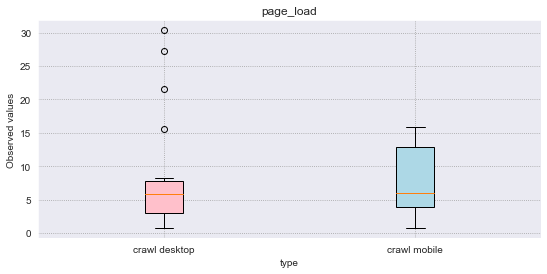

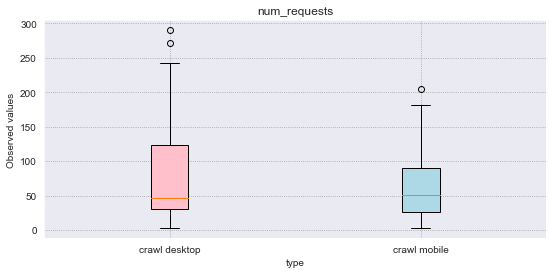

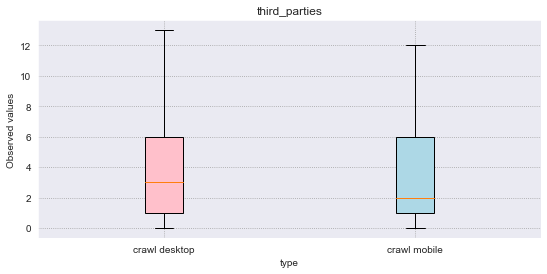

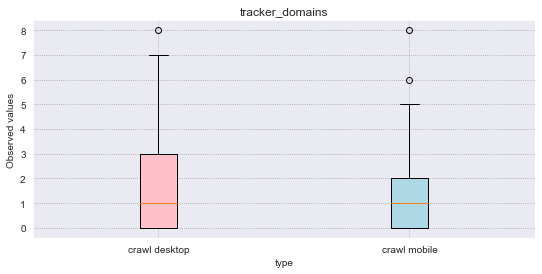

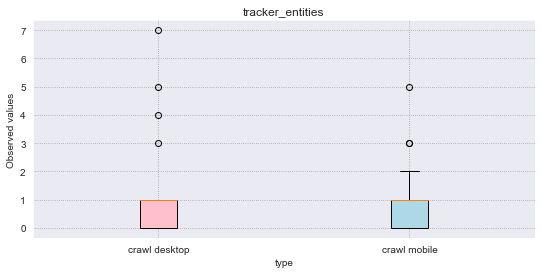

In [ ]:

generate_box_plot(page_load_time_desktop,page_load_time_mobile,"page_load")
generate_box_plot(num_requests_desktop,num_requests_mobile,"num_requests")
generate_box_plot(num_third_parties_desktop,num_third_parties_mobile,"third_parties")
generate_box_plot(num_trackers_domain_desktop,num_trackers_domain_mobile,"tracker_domains")
generate_box_plot(num_trackers_ent_desktop,num_trackers_ent_mobile,"tracker_entities")



In [ ]:
page_load_time_desktop=np.array(page_load_time_desktop)
page_load_time_mobile=np.array(page_load_time_mobile)

num_requests_desktop=np.array(num_requests_desktop)
num_requests_mobile=np.array(num_requests_mobile)

num_third_parties_desktop=np.array(num_third_parties_desktop)
num_third_parties_mobile=np.array(num_third_parties_mobile)

num_trackers_domain_desktop=np.array(num_trackers_domain_desktop)
num_trackers_domain_mobile=np.array(num_trackers_domain_mobile)

num_trackers_ent_desktop=np.array(num_trackers_ent_desktop)
num_trackers_ent_mobile=np.array(num_trackers_ent_mobile)

In [ ]:
page_load_time_desktop_stats=[np.min(page_load_time_desktop),np.max(page_load_time_desktop),np.median(page_load_time_desktop)]
page_load_time_mobile_stats=[np.min(page_load_time_mobile),np.max(page_load_time_mobile),np.median(page_load_time_mobile)]

num_requests_desktop_stats=[np.min(num_requests_desktop),np.max(num_requests_desktop),np.median(num_requests_desktop)]
num_requests_mobile_stats=[np.min(num_requests_mobile),np.max(num_requests_mobile),np.median(num_requests_mobile)]

num_third_parties_desktop_stats=[np.min(num_third_parties_desktop),np.max(num_third_parties_desktop),np.median(num_third_parties_desktop)]
num_third_parties_mobile_stats=[np.min(num_third_parties_mobile),np.max(num_third_parties_mobile),np.median(num_third_parties_mobile)]

num_trackers_domain_desktop_stats=[np.min(num_trackers_domain_desktop),np.max(num_trackers_domain_desktop),np.median(num_trackers_domain_desktop)]
num_trackers_domain_mobile_stats=[np.min(num_trackers_domain_mobile),np.max(num_trackers_domain_mobile),np.median(num_trackers_domain_mobile)]

num_trackers_ent_desktop_stats=[np.min(num_trackers_ent_desktop),np.max(num_trackers_ent_desktop),np.median(num_trackers_ent_desktop)]
num_trackers_ent_mobile_stats=[np.min(num_trackers_ent_mobile),np.max(num_trackers_ent_mobile),np.median(num_trackers_ent_mobile)]


In [ ]:
print("page load desktop",page_load_time_desktop_stats)
print("page load mobile",page_load_time_mobile_stats)

print("requests desktop",num_requests_desktop_stats)
print("requests mobile",num_requests_mobile_stats)

print("third parties desktop",num_third_parties_desktop_stats)
print("third parties mobile",num_third_parties_mobile_stats)

print("trackers desktop",num_trackers_domain_desktop_stats)
print("trackers mobile",num_trackers_domain_mobile_stats)

print("Tracker entities",num_trackers_ent_desktop_stats)
print("Tracker entities",num_trackers_ent_mobile_stats)






page load desktop [0.7632961273193359, 30.354785203933716, 5.7696897983551025]
page load mobile [0.8234801292419434, 15.861424922943115, 5.978036522865295]
requests desktop [3, 290, 47.0]
requests mobile [3, 204, 51.5]
third parties desktop [0, 13, 3.0]
third parties mobile [0, 12, 2.0]
trackers desktop [0, 8, 1.0]
trackers mobile [0, 8, 1.0]
Tracker entities [0, 7, 1.0]
Tracker entities [0, 5, 1.0]


In [ ]:
def get_top_elements(domains,num):
    domains_count=dict(Counter(domains))
    domains_sorted = sorted(domains_count, key=domains_count.get, reverse=True)
    i=0
    for e in domains_sorted:
        print(e,domains_count[e])
        i=i+1
        if (i==num):
            return


In [ ]:
print("*******************top five desktop domains*************")
get_top_elements(third_parties_desktop_list,5)
print("*******************top five mobile domains**************")
get_top_elements(third_parties_mobile_list,5)

*******************top five desktop domains*************
gstatic.com 5
google.com 5
akamaized.net 3
facebook.com 3
fonts.googleapis.com 2
*******************top five mobile domains**************
gstatic.com 4
google.com 4
doubleclick.net 2
fbcdn.net 2
akamaized.net 2


In [ ]:
print("*******************top five desktop trackers*************")
get_top_elements(tracker_domain_desktop_list,10)
print("*******************top five mobile trackers**************")
get_top_elements(tracker_domain_mobile_list,10)

*******************top five desktop trackers*************
gstatic.com 5
google.com 5
facebook.com 3
doubleclick.net 2
fbcdn.net 2
live.com 2
facebook.net 2
demdex.net 2
scorecardresearch.com 2
youtube.com 1
*******************top five mobile trackers**************
gstatic.com 4
google.com 4
doubleclick.net 2
fbcdn.net 2
facebook.com 2
facebook.net 2
scorecardresearch.com 2
amazon-adsystem.com 2
google-analytics.com 2
ggpht.com 1


In [ ]:
print("*******************top five desktop entities*************")
get_top_elements(tracker_ent_desktop_list,5)
print("*******************top five mobile entities**************")
get_top_elements(tracker_ent_mobile_list,5)

*******************top five desktop entities*************
Google LLC 7
Facebook, Inc. 4
Microsoft Corporation 4
Twitter, Inc. 2
Adobe Inc. 2
*******************top five mobile entities**************
Google LLC 7
Facebook, Inc. 3
Microsoft Corporation 3
comScore, Inc 2
Amazon Technologies, Inc. 2


In [ ]:
def generate_scatter_plot(data_desktop,data_mobile,tranco_desktop,tranco_mobile,x_label,y_label):
    fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(24, 8))
    #ax1.yaxis.grid(True)
    #ax1.xaxis.grid(True)
    ax1.set_xlabel(x_label,fontsize=16)
    ax1.set_ylabel(y_label,fontsize=16)
    ax1.set_title("Crawl Desktop",fontsize=22)
    #sns.regplot(x=tranco_desktop, y=data_desktop, ax=ax1, marker='o', c='b', edgecolor='b')
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    sns.regplot(x=np.array(tranco_desktop,dtype='int'), y=np.array(data_desktop,dtype='int'), ax=ax1)
    #ax2.yaxis.grid(True)
    #ax2.xaxis.grid(True)
    ax2.set_xlabel(x_label,fontsize=16)
    ax2.set_ylabel(y_label,fontsize=16)
    ax2.set_title("Crawl Mobile",fontsize=22)
    #sns.regplot(x=tranco_mobile, y=data_mobile,ax=ax2, marker='o', c='b', edgecolor='b')
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    sns.regplot(x=np.array(tranco_mobile,dtype='int'), y=np.array(data_mobile,dtype='int'), ax=ax2)
    plt.savefig(y_label+'.jpg')
    plt.show()

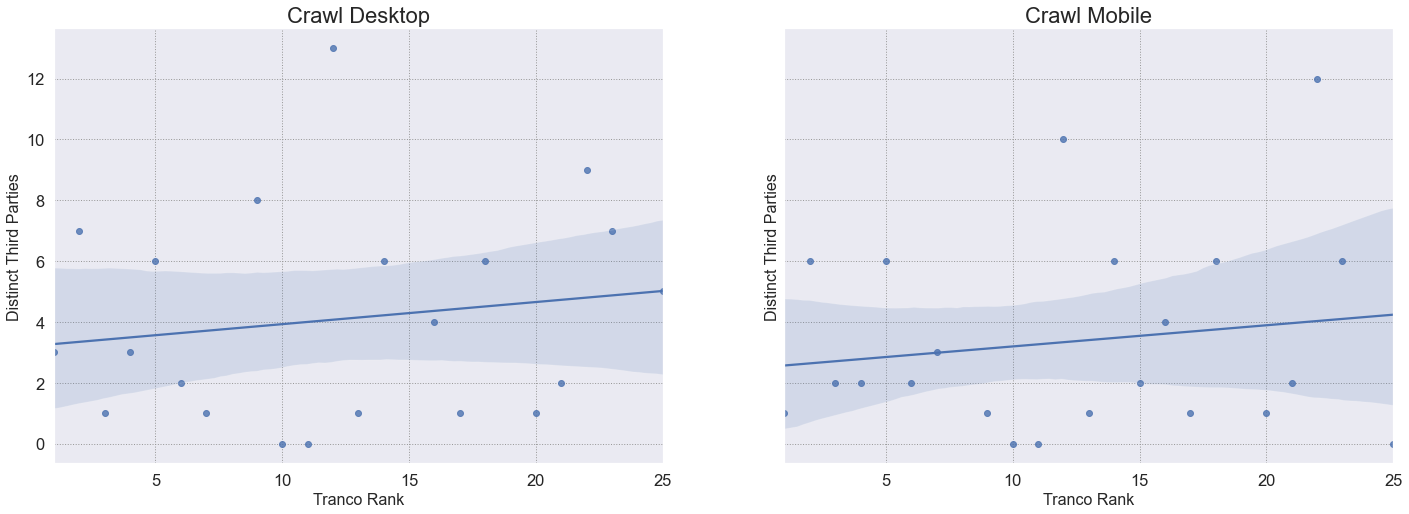

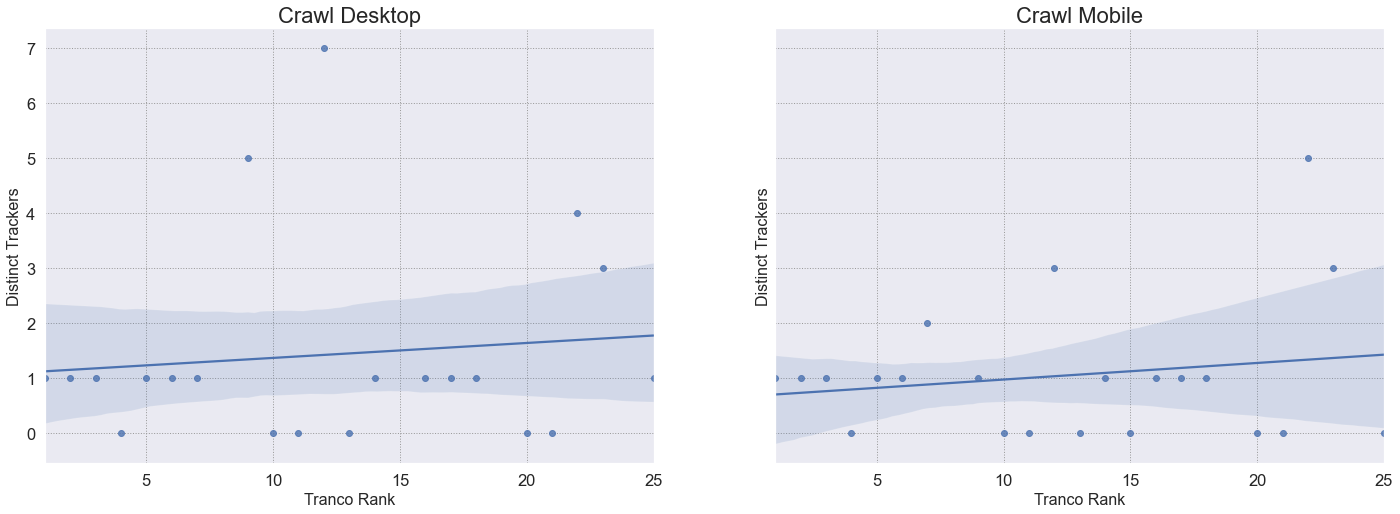

In [ ]:
    generate_scatter_plot(num_third_parties_desktop,num_third_parties_mobile,analysis_tranco_desktop,analysis_tranco_mobile,"Tranco Rank","Distinct Third Parties")

    generate_scatter_plot(num_trackers_ent_desktop,num_trackers_ent_mobile,analysis_tranco_desktop,analysis_tranco_mobile,"Tranco Rank","Distinct Trackers")

In [ ]:
print(118.89.204.198)